In [8]:
import geopandas as gpd
import geoplot as gplt
import pandas as pd
import pickle

Get HSA names

In [9]:
data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_with_state_fips.csv')
data_by_HSA.rename(columns={'health_service_area_number': 'HSA_ID'}, inplace=True)


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_89714/2904833141.py:1: DtypeWarning: Columns (43,45,46,48,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_with_state_fips.csv')


Functions

In [3]:
# Load the json file with county coordinates
geoData = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')

# Make sure the "id" column is an integer
geoData.id = geoData.id.astype(str).astype(int)

# Try and match to states 
census_data = pd.read_csv('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/unemployment-x.csv')

geoData = geoData.merge(census_data, left_on=['id'], right_on=['id'])

In [4]:
def convert_state_to_code(dataframe, column_name):
    # List of state names in alphabetical order, including Washington, D.C.
    state_names = [
        'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
        'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
        'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
        'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
        'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
        'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota',
        'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
        'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
        'West Virginia', 'Wisconsin', 'Wyoming', 'Washington D.C.'
    ]

    # Create a dictionary to map state names to numerical codes
    state_to_code = {state: f'{index + 1:02}' for index, state in enumerate(state_names)}

    # Create a new column "state_code" based on the mapping
    dataframe['state_code'] = dataframe[column_name].map(state_to_code)
    
    return dataframe

In [5]:

data_by_HSA = convert_state_to_code(data_by_HSA, 'state')

In [ ]:
geoData['HSA_ID'] = None
for i, name in enumerate(geoData['id']):
    state = geoData.loc[i, 'state']
    filtered_rows = data_by_HSA[data_by_HSA['fips'] == name ]

    if(len(filtered_rows) > 1): #ensures that only HSAs that are represented in the geoData are used
        geoData.loc[i, 'HSA_ID'] = filtered_rows['HSA_ID'].reset_index(drop=True)[0]
        

Add in values of auROC etc

In [ ]:
geoData['accuracy'] = None

for i, HSA in enumerate(data_by_HSA['HSA_ID']):
    auROC = ROC_by_HSA_full[HSA].values()
    geoData.loc[geoData['HSA_ID'] == HSA, 'auROC'] = next(iter(ROC_by_HSA_full[HSA].values()))


Mainland

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_49543/3217479515.py:6: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  geoData_mainland = geoData_mainland.explode()


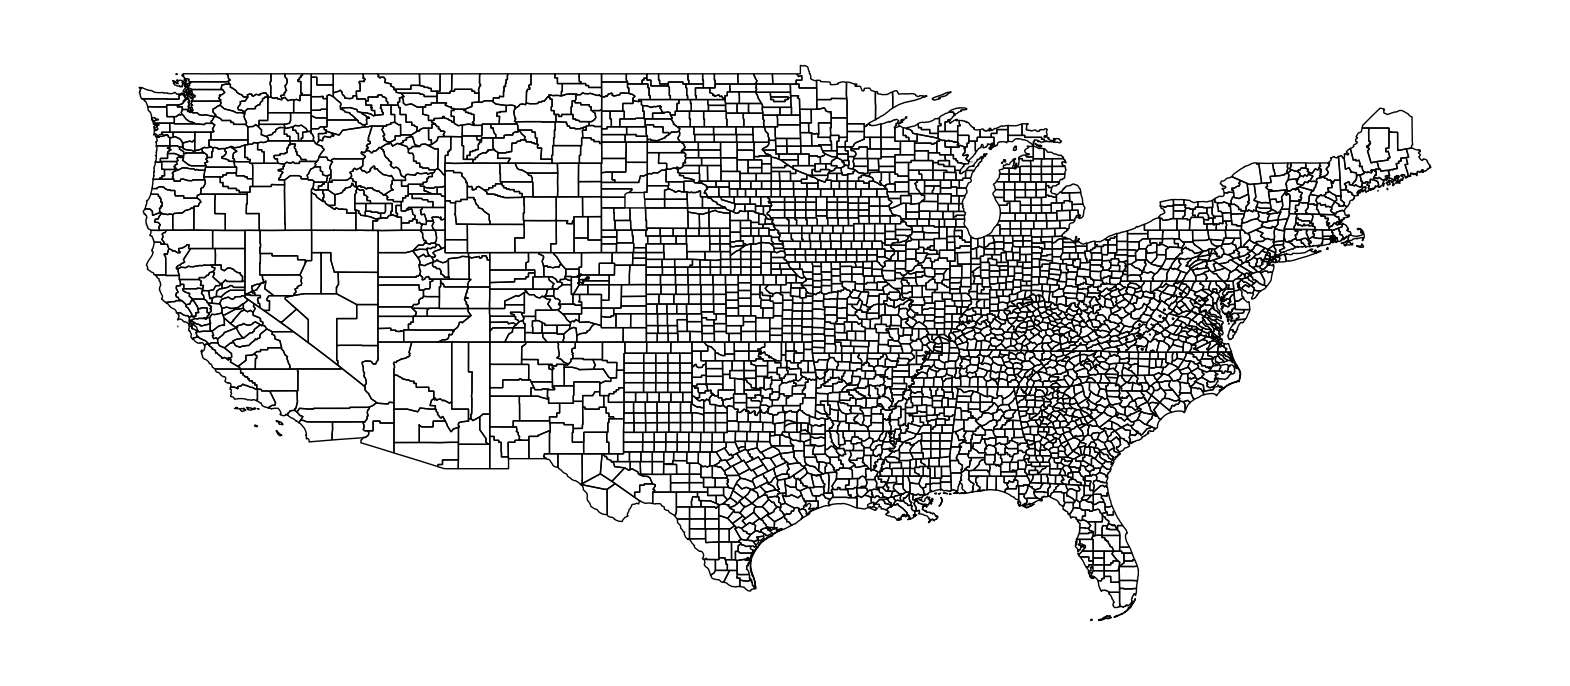

In [ ]:



# Remove Alaska, HI, Puerto Rico (to be plotted later)
stateToRemove = ['02', '15', '72']
geoData_mainland = geoData[~geoData.STATE.isin(stateToRemove)]

# Explode the MultiPolygon geometries into individual polygons
geoData_mainland = geoData_mainland.explode()

# HI 
geoData.id = geoData.id.astype(str).astype(int)

# Remove Alaska, HI, Puerto Rico (to be plotted later)
stateToRemove = ['15']
geoData_HI = geoData[geoData.STATE.isin(stateToRemove)]

# Explode the MultiPolygon geometries into individual polygons
geoData_HI = geoData_HI.explode()

# Alaska 


stateToRemove = ['02']
geoData_AK = geoData[geoData.STATE.isin(stateToRemove)]

# Explode the MultiPolygon geometries into individual polygons
geoData_AK = geoData_AK.explode()



# Plot auROC

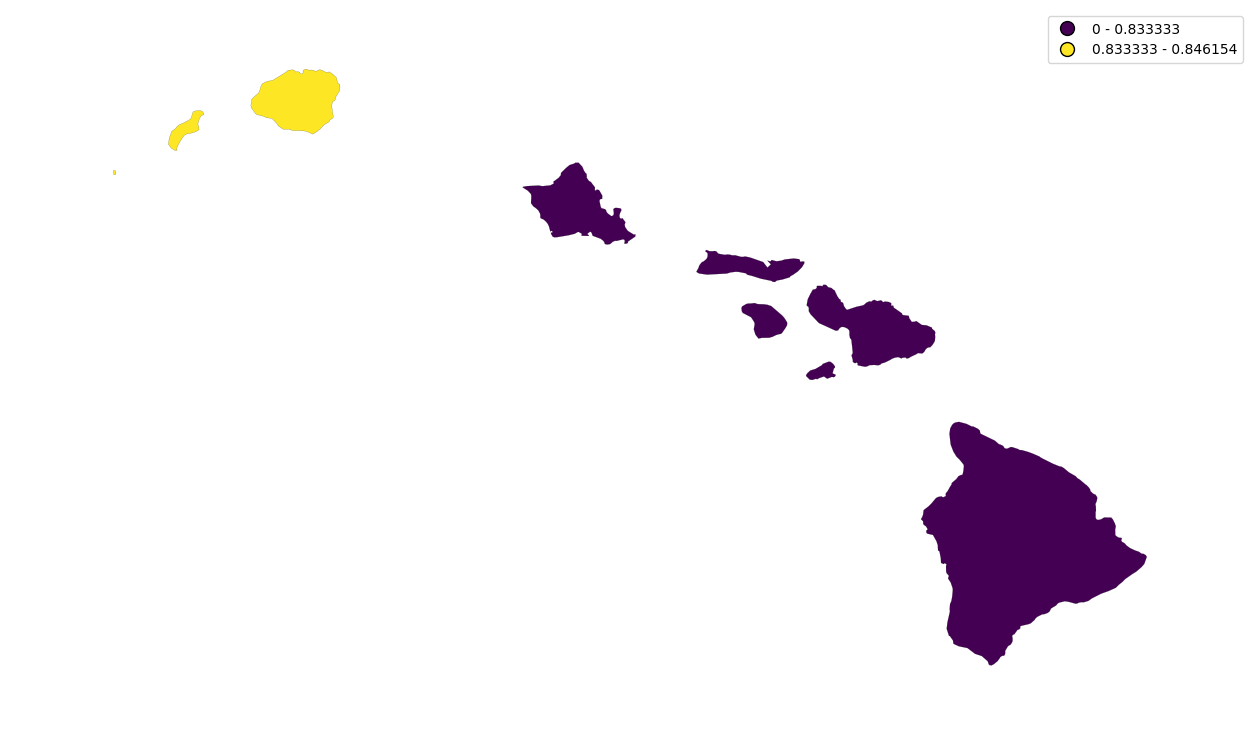

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# Set up the color sheme:
import mapclassify as mc
scheme = mc.Quantiles(geoData_HI['accuracy'], k=2)

gplt.choropleth(geoData_HI, 
    hue="accuracy", 
    linewidth=.1,
    scheme=scheme, cmap='viridis',
    legend=True,
    edgecolor='black',
    ax=ax
);


In [ ]:
geoData_mainland = geoData_mainland.dropna(subset=['accuracy'])


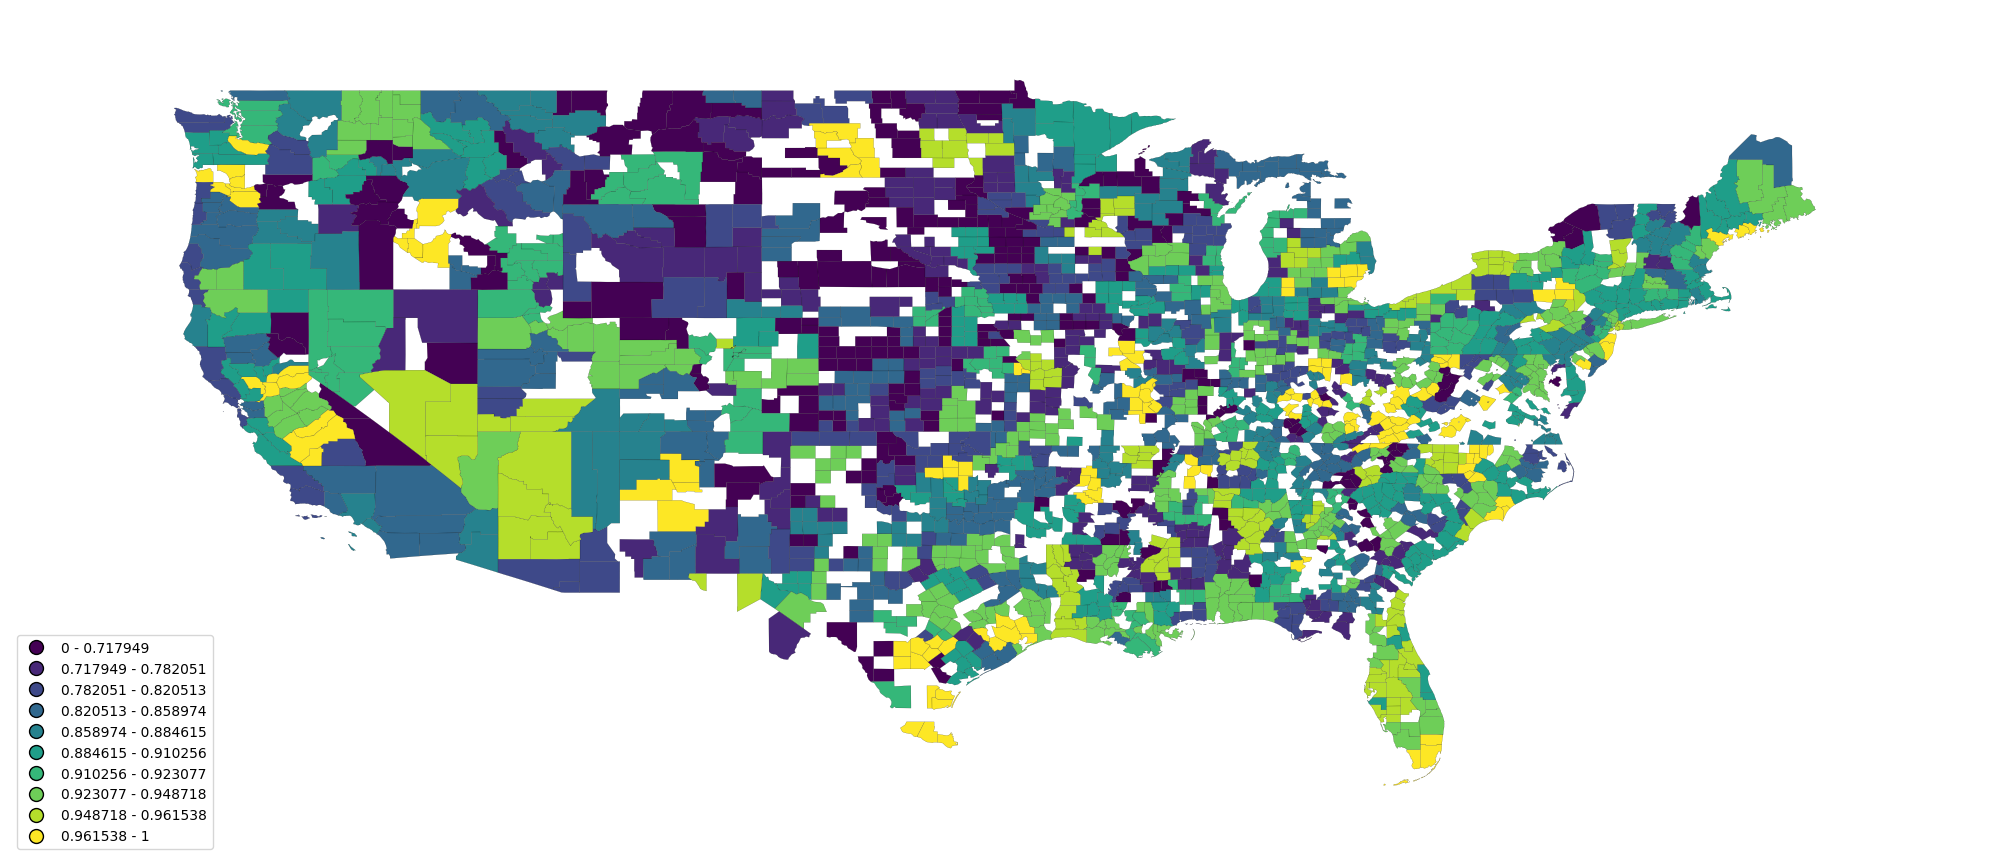

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

# Set up the color sheme:
import mapclassify as mc
scheme = mc.Quantiles(geoData_mainland['accuracy'], k=10)

gplt.choropleth(geoData_mainland, 
    hue="accuracy", 
    linewidth=.1,
    scheme=scheme, cmap='viridis',
    legend=True,
    edgecolor='black',
    ax=ax
);
plt.tight_layout()
plt.savefig('Graphs/USA_mainland_accuracy.png', dpi = 300)

/Users/rem76/miniconda3/envs/COVID_forecasting/lib/python3.11/site-packages/mapclassify/classifiers.py:257: UserWarning: Not enough unique values in array to form 2 classes. Setting k to 1.
  warnings.warn(


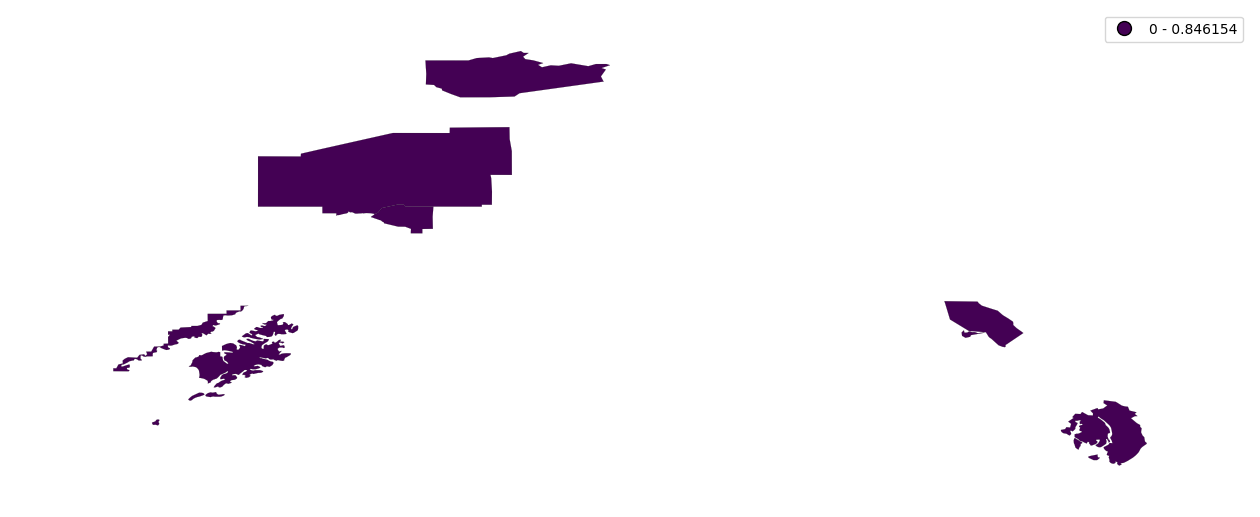

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
geoData_AK = geoData_AK.dropna(subset=['accuracy'])

# Set up the color sheme:
import mapclassify as mc
scheme = mc.Quantiles(geoData_AK['accuracy'], k=2)

gplt.choropleth(geoData_AK, 
    hue="accuracy", 
    linewidth=.1,
    scheme=scheme, cmap='viridis',
    legend=True,
    edgecolor='black',
    ax=ax
);

In [ ]:
data_by_HSA

,Unnamed: 0,date,HSA_ID,health_service_area,health_service_area_population,cases_avg,deaths_avg,cases_avg_per_100k,deaths_avg_per_100k,POPESTIMATE2019,...,two_zeke_time_3,icu_2_time_3,perc_covid_10_time_3,change_admits,change_perc,change_cases,zeke_time_3_14d,two_zeke_time_3_14d,weight,weight_alt
0,1,2020-07-15,1,"Allegany (Cumberland), MD - Garrett, MD",151642,5.62,0.13,3.706097,0.085728,151642,...,False,False,False,1.318896,0.283447,16.0,False,False,0.000021,0.000210
1,2,2020-07-15,1,"Allegany (Cumberland), MD - Garrett, MD",151642,5.62,0.13,3.706097,0.085728,151642,...,False,False,False,0.000000,0.000000,0.0,False,False,0.000021,0.000210
2,3,2020-07-15,1,"Allegany (Cumberland), MD - Garrett, MD",151642,5.62,0.13,3.706097,0.085728,151642,...,False,False,False,0.000000,0.000000,0.0,False,False,0.000021,0.000210
3,4,2020-07-15,1,"Allegany (Cumberland), MD - Garrett, MD",151642,5.62,0.13,3.706097,0.085728,151642,...,False,NaN,False,0.000000,0.000000,0.0,False,False,0.000021,0.000210
4,5,2020-07-15,2,"Kenton (Covington), KY - Campbell, KY",442691,31.43,0.72,7.099760,0.162642,442691,...,False,True,False,0.903565,0.000000,12.0,False,False,0.000062,0.000210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612275,612276,2022-12-28,820,"Anchorage (Anchorage), AK - Matanuska-Susitna ...",547697,37.36,0.44,6.821290,0.080336,547697,...,NaN,NaN,NaN,0.000000,0.000000,-5.0,NaN,NaN,0.001653,0.001244
612276,612277,2022-12-28,821,"Honolulu (Honolulu), HI - Maui, HI",1142066,120.57,0.77,10.557183,0.067422,1142066,...,NaN,NaN,NaN,0.000000,0.000000,-7.0,NaN,NaN,0.003446,0.001244
612277,612278,2022-12-28,822,"Kauai, HI",72293,11.29,0.00,15.617003,0.000000,72293,...,NaN,NaN,NaN,0.000000,0.000000,-7.0,NaN,NaN,0.000218,0.001244
612278,612279,2022-12-28,823,"Hawaii, HI",201513,21.14,0.14,10.490638,0.069474,201513,...,NaN,NaN,NaN,0.000000,0.000000,5.0,NaN,NaN,0.000608,0.001244


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_49543/3464838252.py:9: DtypeWarning: Columns (43,45,46,48,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_with_state_fips.csv')
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_49543/3464838252.py:52: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  geoData_mainland = geoData_mainland.explode()


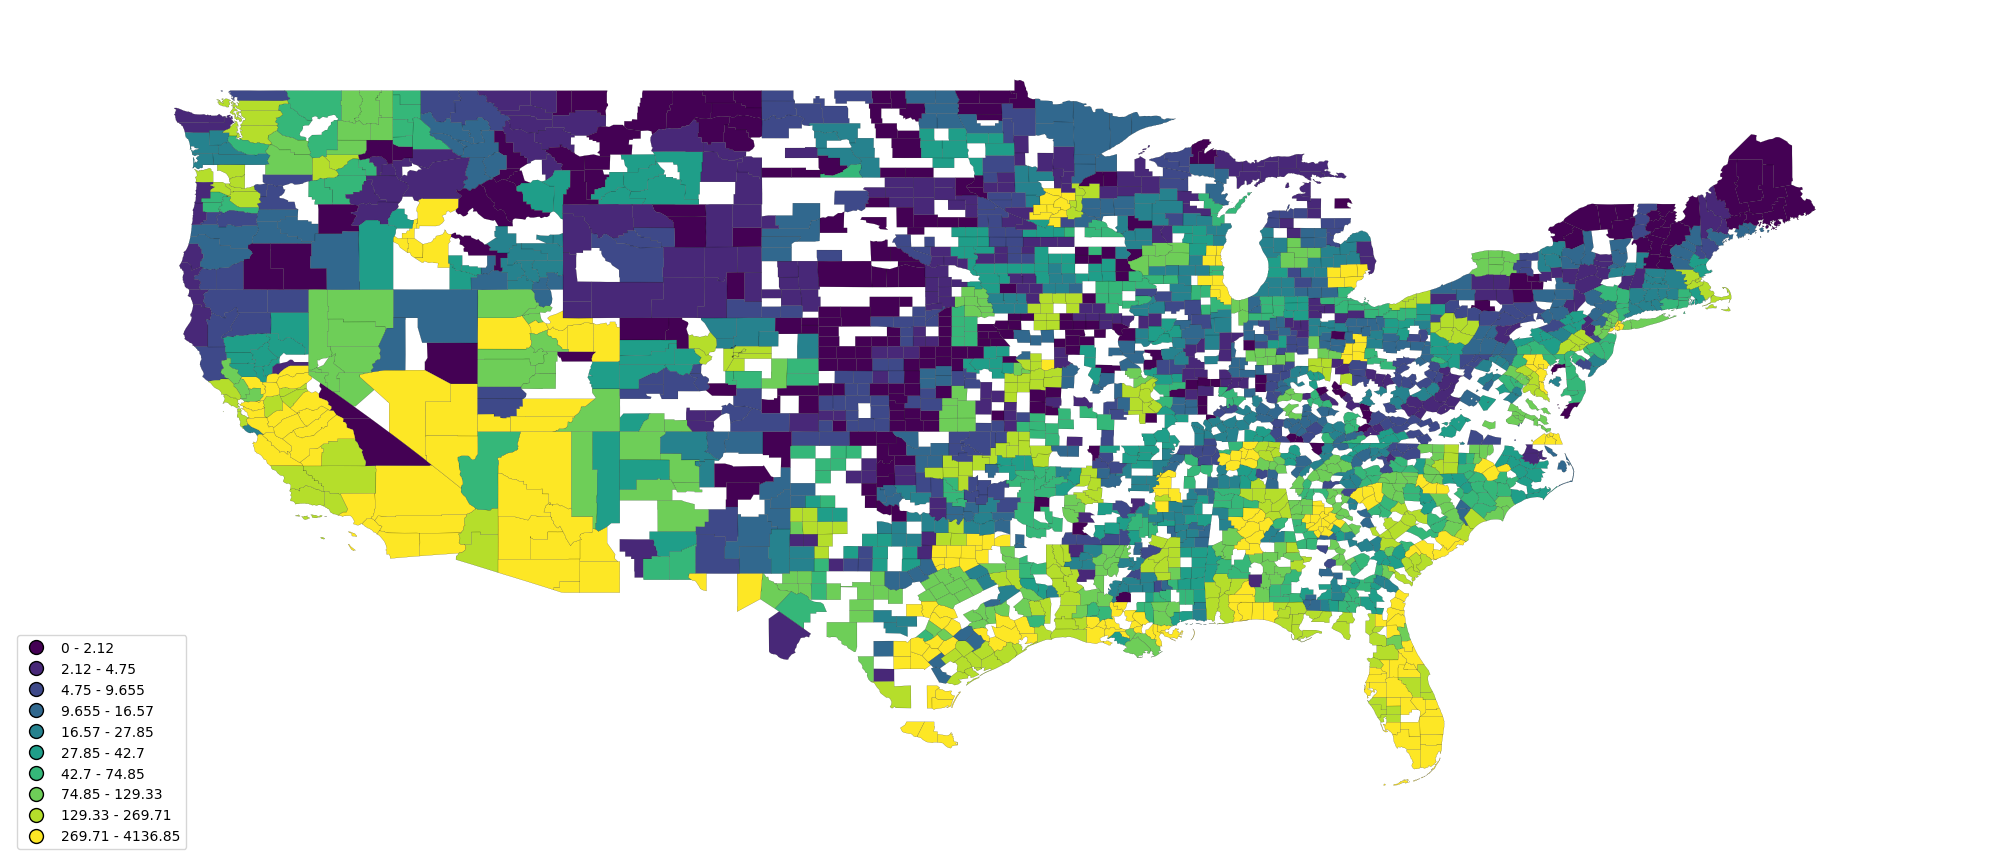

In [ ]:
import geopandas as gpd
import geoplot as gplt
import pandas as pd
import pickle
import mapclassify as mc
import matplotlib.pyplot as plt

#### Load data ###
data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_with_state_fips.csv')
data_by_HSA.rename(columns={"health_service_area_number": "HSA_ID"}, inplace=True)


# Load the json file with county coordinates
geoData = gpd.read_file(
    "https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson"
)

# Make sure the "id" column is an integer
geoData.id = geoData.id.astype(str).astype(int)

# Try and match to states
census_data = pd.read_csv(
    "https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/unemployment-x.csv"
)

geoData = geoData.merge(census_data, left_on=["id"], right_on=["id"])

# Add HSA IDs to geoData and cases_avg
geoData["HSA_ID"] = None
geoData["cases_avg"] = None
for i, name in enumerate(geoData["id"]):
    state = geoData.loc[i, "state"]
    filtered_rows = data_by_HSA[data_by_HSA["fips"] == name]

    if (
        len(filtered_rows) > 1
    ):  # ensures that only HSAs that are represented in the geoData are used
        geoData.loc[i, "HSA_ID"] = filtered_rows["HSA_ID"].reset_index(drop=True)[0]
        geoData.loc[i, "cases_avg"] = filtered_rows["cases_avg"].reset_index(drop=True)[0]

# Remove counties where there are no data (as we may not have data for all counties represented)
geoData = geoData.dropna(subset=['cases_avg'])


### Mainland USA ###

# Remove Alaska, HI, Puerto Rico (to be plotted later)
stateToRemove = ["02", "15", "72"]
geoData_mainland = geoData[~geoData.STATE.isin(stateToRemove)]

# Explode the MultiPolygon geometries into individual polygons
geoData_mainland = geoData_mainland.explode()

# Plot
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

# Set up the color sheme:
scheme = mc.Quantiles(geoData_mainland["cases_avg"], k=10)

gplt.choropleth(
    geoData_mainland,
    hue="cases_avg",
    linewidth=0.1,
    scheme=scheme,
    cmap="viridis",
    legend=True,
    edgecolor="black",
    ax=ax,
)
plt.tight_layout()
